In [ ]:

import os

import torch
import torch.nn as nn
import torch.nn.functional as F

latent_dims = 2
num_epochs = 10
batch_size = 64
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [126]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
   
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode


Number of parameters: 308357


In [127]:


train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    vae.train()
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        # print('1',loss,'2',loss.item)
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    # test
    vae.eval()
    test_loss = 0
    batch = 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            image_batch = data.to(device)

            decode_item, mu, logvar = vae(image_batch)
            loss = vae_loss(decode_item, image_batch, mu, logvar)
            test_loss += loss.item()
            batch += 1


        
    train_loss_avg[-1] /= num_batches
    test_loss_avg = test_loss/batch
    print('Epoch [%d / %d] average training error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    print('Epoch [%d / %d] average  testing error: %f' % (epoch+1, num_epochs, test_loss_avg))

    

Training ...
Epoch [1 / 10] average training error: 11342.415243
Epoch [1 / 10] average  testing error: 10370.970930
Epoch [2 / 10] average training error: 10339.655821
Epoch [2 / 10] average  testing error: 10103.072034
Epoch [3 / 10] average training error: 10142.317985
Epoch [3 / 10] average  testing error: 9954.632475
Epoch [4 / 10] average training error: 10036.740084
Epoch [4 / 10] average  testing error: 9909.604065
Epoch [5 / 10] average training error: 9958.424487
Epoch [5 / 10] average  testing error: 9825.093077
Epoch [6 / 10] average training error: 9905.126060
Epoch [6 / 10] average  testing error: 9817.763687
Epoch [7 / 10] average training error: 9854.092229
Epoch [7 / 10] average  testing error: 9766.377025
Epoch [8 / 10] average training error: 9813.741584
Epoch [8 / 10] average  testing error: 9772.471282
Epoch [9 / 10] average training error: 9778.985998
Epoch [9 / 10] average  testing error: 9677.346541
Epoch [10 / 10] average training error: 9751.053203
Epoch [10 /

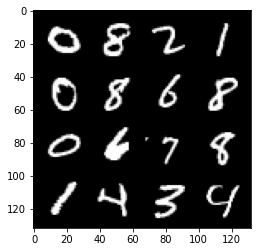

VAE train_images:


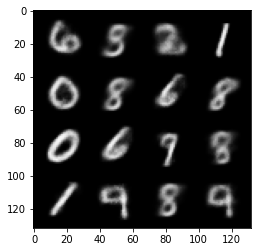

VAE test_images:


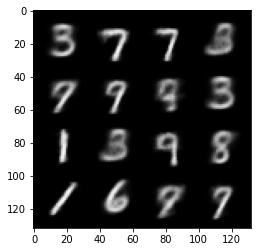

In [128]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:17], 4, 4).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()
train_images, labels = iter(train_dataloader).next()
test_images, labels = iter(test_dataloader).next()

# First visualise the original images


# Reconstruct and visualise the images using the vae
show_image(torchvision.utils.make_grid(train_images[1:17], 4, 4))
plt.show()
print('VAE train_images:')
visualise_output(train_images, vae)

print('VAE test_images:')
visualise_output(test_images, vae)


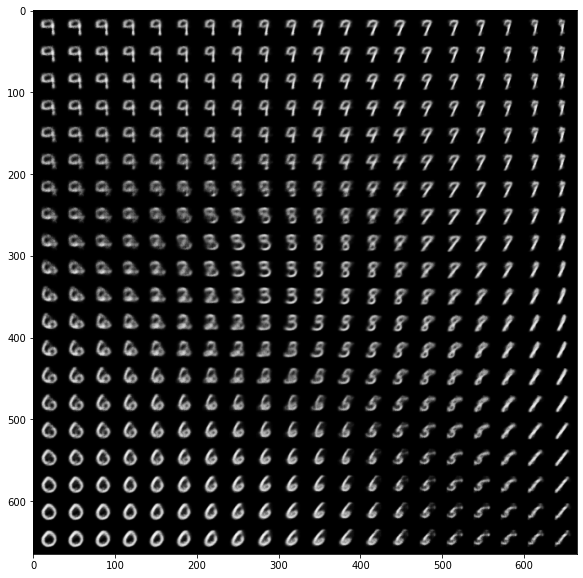

In [129]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

(10000, 2)
[[-0.70984513  0.17798203]
 [ 0.25319734 -1.49210775]
 [ 0.30785134 -0.9823035 ]
 ...
 [-0.10401058  0.030239  ]
 [ 0.75445598 -1.71344495]
 [-0.10835491  0.11823894]]
[2. 7. 4. ... 3. 7. 8.]


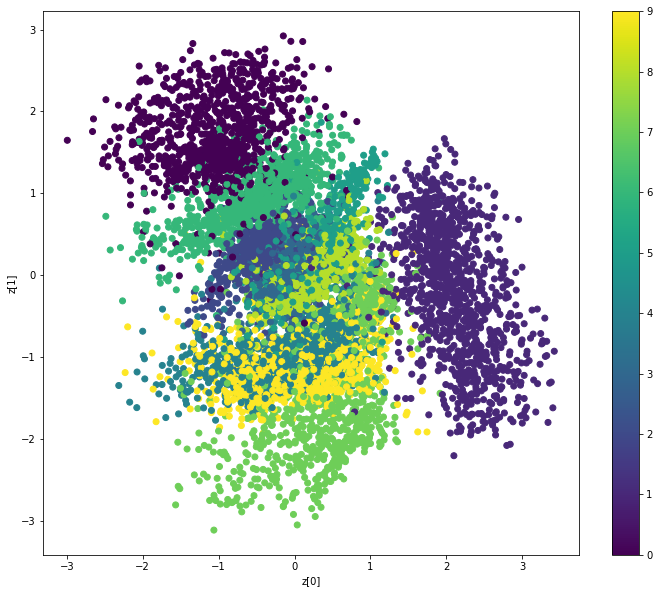

In [130]:

# display a 2D plot of the digit classes in the latent space
# decode_item, mu, logvar = vae(data)
import numpy as np
mu_total = np.array([])
labels = np.array([])
for data, label in test_dataloader:
    # print(label)
    image_batch = data.to(device)
    
    decode_item, mu, logvar = vae(image_batch)
    # print('t',mu_total,mu)
    # print(mu.cpu().detach().numpy())
    mu_total = np.append(mu_total,mu.cpu().detach().numpy())
    # print(mu_total)
    labels = np.append(labels,label.cpu().detach().numpy())
# print(mu)

mu_total = mu_total.reshape((-1,2))
print(mu_total.shape)
print(mu_total)
print(labels)
# numpy.array(labels).reshape(-1)

plt.figure(figsize=(12, 10))
plt.scatter(mu_total[:, 0], mu_total[:, 1], c=labels)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


